<a href="https://colab.research.google.com/github/elifsare/Real-time-Age-Gender-Ethnicity-Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 77% 49.0M/63.2M [00:00<00:00, 66.2MB/s]
100% 63.2M/63.2M [00:00<00:00, 83.7MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip '/content/age-gender-and-ethnicity-face-data-csv.zip' -d dataset

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: dataset/age_gender.csv  


In [6]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from keras.models import Sequential     
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, RMSprop, Adamax 
from keras.utils import np_utils  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('/content/dataset/age_gender.csv')

In [8]:
## Converting pixels into numpy array
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [9]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

data visulate

In [10]:
df1 = df.drop('img_name', axis=1)
y1 = df1.drop("pixels", axis=1)

In [11]:
y1.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


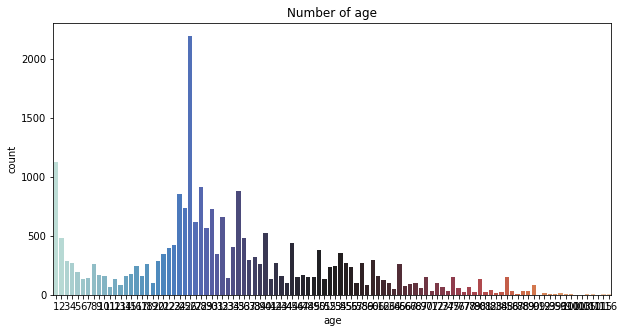

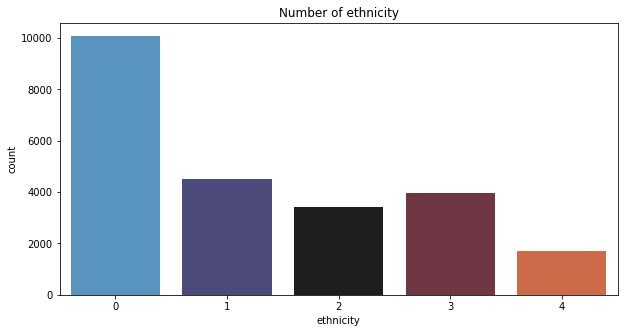

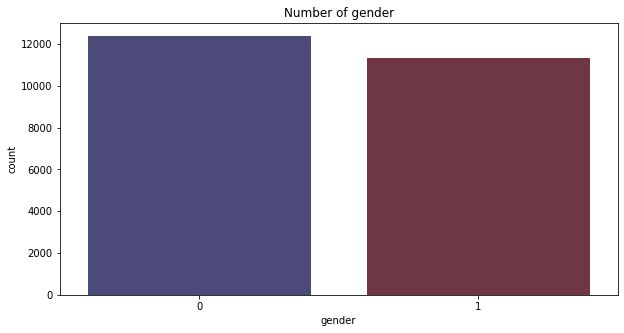

In [12]:
import seaborn as sns
for i in y1.columns:
    plt.figure(figsize=(10,5))
    g = sns.countplot(y1[i], palette="icefire")
    plt.title("Number of {}".format(i))

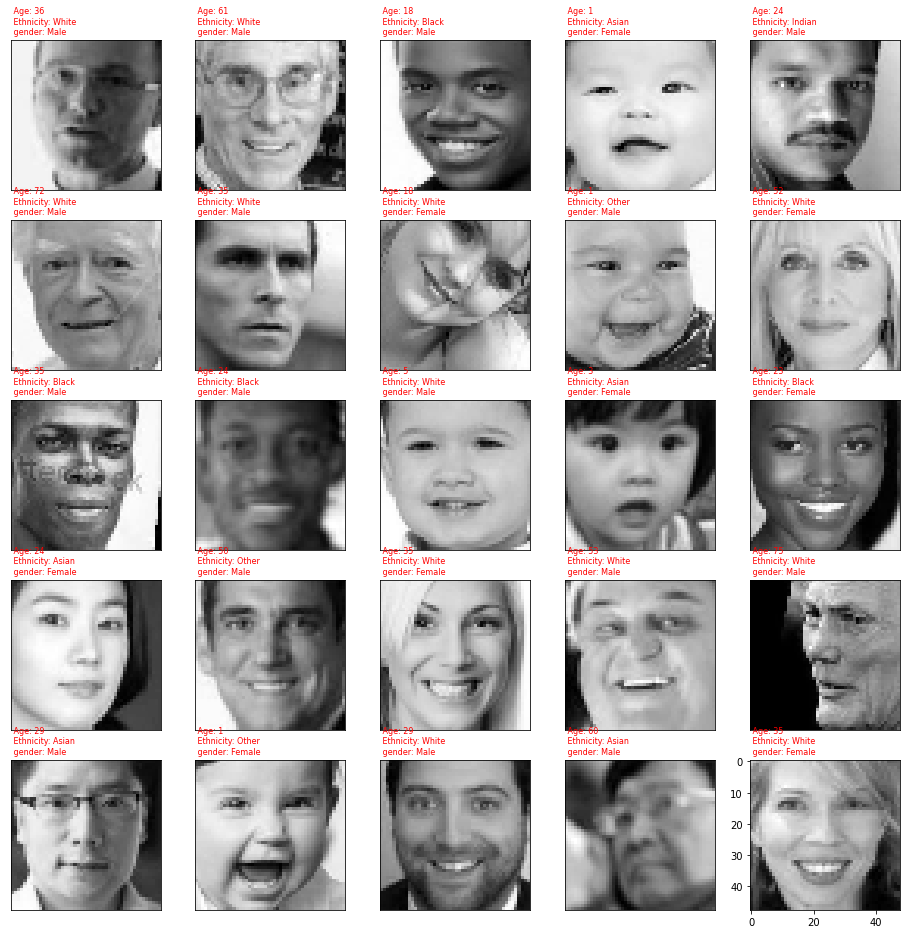

In [13]:
plt.figure(figsize=(16, 16))

for i in range(25):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], 
                                                             {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}[df['ethnicity'].iloc[index]], 
                                                             {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),
              loc="left",color='red',
              fontsize = 8)

plt.show()

In [14]:
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48,1))

In [15]:
def m_subplot(h):
  plt.figure(figsize = (14,3))
  plt.subplot(1,2,1)
  plt.ylabel('Loss', fontsize = 15)
  plt.plot(h.history['loss'], color = 'b', label = 'Training Loss')
  plt.plot(h.history['val_loss'], color = 'r', label = 'Validation Loss')

  plt.subplot(1,2,2)
  plt.ylabel('Accuracy', fontsize = 15)
  plt.plot(h.history['accuracy'], color = 'b', label = 'Training Accuracy')
  plt.plot(h.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

  plt.legend(loc = 'lower right')

  plt.show()

# Age Model

In [16]:
y = df['age']
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=30)

image generetor

In [17]:
train_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    validation_split = 0.2
                                    )
validation_generator = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [18]:
train_flow_age = train_generator.flow(X_test_age,
                                  y_test_age,
                                  batch_size=64)

validation_flow_age = validation_generator.flow(X_test_age,
                                            y_test_age,
                                            batch_size=64)

In [19]:
model_age = Sequential()

model_age.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))

model_age.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Conv2D(64, (3, 3), activation='relu'))
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Conv2D(128, (3, 3), activation='relu'))
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Flatten())

model_age.add(Dense(64, activation='relu'))
model_age.add(Dropout(rate=0.2))

model_age.add(Dense(1, activation = 'relu'))

model_age.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [20]:
root = '/content/drive/MyDrive/DeepLearningProject/Gender&Age/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model_age.h5', verbose = 1, save_best_only = True)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [22]:
batch_size = 64
epochs = 60

In [23]:
h_age = model_age.fit(train_flow_age, 
                      epochs= epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      validation_data= validation_flow_age,
                      callbacks= callbacks_list)

Epoch 1/60
112/112 [==============================] - ETA: 0s - loss: 428.0888 - mae: 15.8687
Epoch 1: val_loss improved from inf to 1290.98267, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
112/112 [==============================] - 13s 40ms/step - loss: 428.0888 - mae: 15.8687 - val_loss: 1290.9827 - val_mae: 30.2317 - lr: 0.0010
Epoch 2/60
112/112 [==============================] - ETA: 0s - loss: 304.4595 - mae: 13.3402
Epoch 2: val_loss improved from 1290.98267 to 1228.09338, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
112/112 [==============================] - 6s 51ms/step - loss: 304.4595 - mae: 13.3402 - val_loss: 1228.0934 - val_mae: 29.4727 - lr: 0.0010
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 268.5408 - mae: 12.5376
Epoch 3: val_loss improved from 1228.09338 to 1053.34509, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoi

In [24]:
train_loss, train_acc = model_age.evaluate(train_flow_age)
test_loss, test_acc   = model_age.evaluate(validation_flow_age)

112/112 [==============================] - 1s 6ms/step - loss: 85.8351 - mae: 6.8855


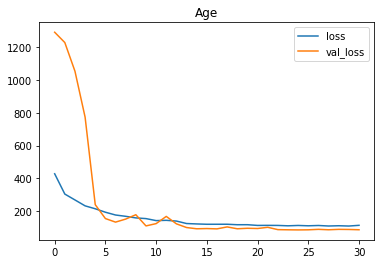

In [25]:
losses_age = pd.DataFrame(h_age.history)
losses_age[['loss','val_loss']].plot(title='Age')

# Gender Model

In [26]:
y = df['gender']
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X,
                                                                                y, 
                                                                                test_size=0.3, 
                                                                                random_state=40)

image generetor

In [27]:
batch_size = 64
epoch = 60

In [28]:
train_flow_gender = train_generator.flow(X_test_gender,
                                  y_test_gender,
                                  batch_size=batch_size)

validation_flow_gender = validation_generator.flow(X_test_gender,
                                            y_test_gender,
                                            batch_size=batch_size)

In [29]:
model_gender = Sequential()

model_gender.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model_gender.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))

model_gender.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))
    
model_gender.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))

model_gender.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPool2D(pool_size=(2, 2)))

model_gender.add(Flatten()) 
model_gender.add(Dense(256,activation = 'relu'))
model_gender.add(BatchNormalization())
    
model_gender.add(Dense(512,activation = 'relu'))
model_gender.add(BatchNormalization())
model_gender.add(Dropout(0.2))

model_gender.add(Dense(1, activation='sigmoid'))


model_gender.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_gender.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_2 (Batc  (None, 24, 24, 128)     

In [30]:
checkPointer = ModelCheckpoint(root + 'checkPoint_model_gender.h5', verbose = 1, save_best_only = True)

In [31]:
callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [32]:
h_gender = model_gender.fit(train_flow_gender, 
                            epochs= epochs,
                            batch_size = batch_size,
                            shuffle = True,
                            validation_split=0.1,
                            validation_data= validation_flow_gender,
                            callbacks= callbacks_list)

Epoch 1/60
112/112 [==============================] - ETA: 0s - loss: 7.6913 - accuracy: 0.6616
Epoch 1: val_loss improved from inf to 7.55595, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 8s 56ms/step - loss: 7.6913 - accuracy: 0.6616 - val_loss: 7.5559 - val_accuracy: 0.5235 - lr: 0.0100
Epoch 2/60
112/112 [==============================] - ETA: 0s - loss: 7.2788 - accuracy: 0.7202
Epoch 2: val_loss improved from 7.55595 to 7.31098, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 5s 46ms/step - loss: 7.2788 - accuracy: 0.7202 - val_loss: 7.3110 - val_accuracy: 0.5165 - lr: 0.0100
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 6.9268 - accuracy: 0.7629
Epoch 3: val_loss improved from 7.31098 to 6.93956, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkP

In [33]:
train_loss, train_acc = model_gender.evaluate(train_flow_gender)
test_loss, test_acc   = model_gender.evaluate(validation_flow_gender)

112/112 [==============================] - 1s 10ms/step - loss: 0.7812 - accuracy: 0.9338


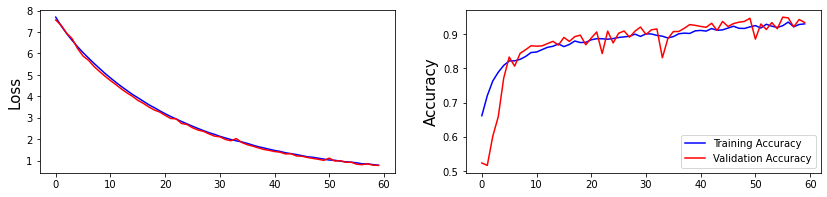

In [34]:
m_subplot(h_gender)

# Ethnicity model

In [35]:
y = df['ethnicity']

In [36]:
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,
                                                                                            y,
                                                                                            test_size = 0.3,
                                                                                            random_state = 40)

image generetor

In [37]:
train_flow_ethnicity = train_generator.flow(X_test_ethnicity,
                                            y_test_ethnicity,
                                            batch_size=64)

validation_flow_ethnicity= validation_generator.flow(X_test_ethnicity,
                                                     y_test_ethnicity,
                                                     batch_size=64)

In [38]:
model_ethnicity = Sequential()

model_ethnicity.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model_ethnicity.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPool2D(pool_size=(2, 2)))

model_ethnicity.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPool2D(pool_size=(2, 2)))
    
model_ethnicity.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPool2D(pool_size=(2, 2)))

model_ethnicity.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(MaxPool2D(pool_size=(2, 2)))

model_ethnicity.add(Flatten()) 
model_ethnicity.add(Dense(256,activation = 'relu'))
model_ethnicity.add(BatchNormalization())
    
model_ethnicity.add(Dense(512,activation = 'relu'))
model_ethnicity.add(BatchNormalization())
model_ethnicity.add(Dropout(0.2))

model_ethnicity.add(Dense(5, activation='sigmoid'))

model_ethnicity.compile(optimizer='rmsprop',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])


model_ethnicity.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 batch_normalization_8 (Batc  (None, 24, 24, 128)     

In [39]:
checkPointer = ModelCheckpoint(root + 'checkPoint_model_ethnicity.h5', verbose = 1, save_best_only = True)

In [40]:
callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [41]:
h_ethnicity = model_ethnicity.fit(train_flow_ethnicity, 
                                  epochs= epochs,
                                  batch_size=batch_size,
                                  shuffle = True,
                                  validation_split=0.1,
                                  validation_data= validation_flow_ethnicity,
                                  callbacks= callbacks_list)

Epoch 1/60


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


111/112 [============================>.] - ETA: 0s - loss: 5.4652 - accuracy: 0.3934
Epoch 1: val_loss improved from inf to 2.57080, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_ethnicity.h5
112/112 [==============================] - 7s 50ms/step - loss: 5.4358 - accuracy: 0.3933 - val_loss: 2.5708 - val_accuracy: 0.4470 - lr: 0.0010
Epoch 2/60
111/112 [============================>.] - ETA: 0s - loss: 1.9093 - accuracy: 0.4696
Epoch 2: val_loss did not improve from 2.57080
112/112 [==============================] - 5s 45ms/step - loss: 1.9099 - accuracy: 0.4695 - val_loss: 3.3132 - val_accuracy: 0.4258 - lr: 0.0010
Epoch 3/60
111/112 [============================>.] - ETA: 0s - loss: 1.7434 - accuracy: 0.5453
Epoch 3: val_loss improved from 2.57080 to 2.22368, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_ethnicity.h5
112/112 [==============================] - 5s 48ms/step - loss: 1.7427 - accuracy: 0.5

In [42]:
train_loss, train_acc = model_ethnicity.evaluate(train_flow_ethnicity)
test_loss, test_acc   = model_ethnicity.evaluate(validation_flow_ethnicity)

112/112 [==============================] - 1s 10ms/step - loss: 0.2720 - accuracy: 0.9398


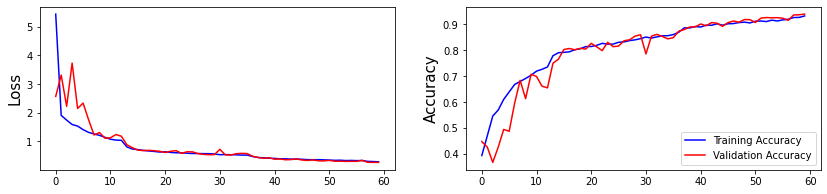

In [43]:
m_subplot(h_ethnicity)